# Estimating segmentation uncertainty of a convolution neural network to segment retina image (Kendall and Gal)

- Estimation of aleatoric and epistemic uncertainty in a DNN model for segmentation, based on the following papers:
  - Gal and Ghahramani (2016) Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning  
  https://arxiv.org/pdf/1506.02142.pdf
  - Kendall and Gal (2017), What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?  
  https://arxiv.org/pdf/1703.04977.pdf
  - Kwon, Won, Kim and Paik (2018), Uncertainty quantification using Bayesian neural networks in classification  
  https://openreview.net/pdf?id=Sk_P2Q9sG


- Trains a modified UNet on the [DRIVE dataset](http://www.isi.uu.nl/Research/Databases/DRIVE/) [Staal et al, 2004] to segment retinal images:
  - J.J. Staal, M.D. Abramoff, M. Niemeijer, M.A. Viergever, B. van Ginneken, "[Ridge based vessel segmentation in color images of the retina](http://www.isi.uu.nl/Research/Databases/DRIVE/id=855.html)", IEEE Transactions on Medical Imaging, 2004, vol. 23, pp. 501-509.


## Approach

1. Train a UNet as usual, but with Dropout
2. At inference time, run model `T` times while applying Dropout and save individual predictions in array `p_hat` (`shape=(T, height, width, channels)`)
    ```
    x = Dropout(rate=0.25)(x, training=True) 
    ```
See https://github.com/keras-team/keras/issues/9412#issuecomment-366487249
3. Then, compute the mean prediction and the aleatoric and epistemic uncertainties as:
    ```
    prediction = np.mean(p_hat, axis=0)
    aleatoric  = np.mean(p_hat*(1-p_hat), axis=0)
    epistemic  = np.mean(p_hat**2, axis=0) - np.mean(p_hat, axis=0)**2
    ```

# Imports

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os, glob
import pandas as pd # load csv
import zipfile # extract zip
from skimage.external import tifffile # read tiff images
from skimage.io import imread # read gif images
from skimage.transform import resize # resize images

# Preparing the data

__Loading the image data__

The image data will be imported as tensors of shape: NUM x WIDTH x HEIGHT.

The labels will be imported as tensors of shape: NUM x 1

In [2]:
# unzip data set
with zipfile.ZipFile("../data/DRIVE_retinal_image_data.zip","r") as zip_ref:
    zip_ref.extractall("../data")

In [3]:
# load training images
fns = sorted(glob.glob('../data/DRIVE/training/images/*.tif'))
#print(fns)
x_train = np.array([tifffile.imread(fn) for fn in fns])

# load test images
fns = sorted(glob.glob('../data/DRIVE/test/images/*.tif'))
#print(fns)
x_test = np.array([tifffile.imread(fn) for fn in fns])
print(x_train.shape)
print(x_test.shape)

/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


(31, 584, 565, 3)
(9, 584, 565, 3)


In [4]:
# load training annotations
fns = sorted(glob.glob('../data/DRIVE/training/labels/*_manual1.gif'))
y_train = np.array([imread(fn) for fn in fns]) # read images
# add inverse channel (one-hot format)
y_train_inv = np.array(~y_train.astype(np.bool), np.float32)
y_train = np.stack([y_train, y_train_inv], axis=-1)
print(y_train.shape)

# load test annotations
fns = sorted(glob.glob('../data/DRIVE/test/labels/*_manual1.gif'))
y_test = np.array([imread(fn) for fn in fns]) # read images
# add inverse channel (one-hot format)
y_test_inv = np.array(~y_test.astype(np.bool), np.float32)
y_test = np.stack([y_test, y_test_inv], axis=-1)
print(y_test.shape)


(31, 584, 565, 2)
(9, 584, 565, 2)


**Preprocessing**

- Convert to float32
- Rescale to 0-1 interval

In [5]:
def preprocess(ims):
    # convert to float32
    ims = ims.astype(np.float32)

    # scale to 0-1 interval
    if ims.max() > 1.0:
        ims /= 255.
    
    print('min: {}, max: {}, shape: {}, type: {}'.format(ims.min(), ims.max(), ims.shape, ims.dtype))
    return ims

x_train = preprocess(x_train)
x_test = preprocess(x_test)

y_train = preprocess(y_train)
y_test = preprocess(y_test)


min: 0.0, max: 1.0, shape: (31, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (9, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (31, 584, 565, 2), type: float32
min: 0.0, max: 1.0, shape: (9, 584, 565, 2), type: float32


**Data augmentation**

- Generate a large collection of small image/segmentation snippets

In [6]:
def random_snippet(x, y, size=(48,48), rotate=True, flip=True):
    '''sample snippets from images. return image tuple (real, segmentation) of size `size` '''
    
    assert x.shape[:2] == y.shape[:2]
    
    # get image sample
    sample = np.random.randint(0, x.shape[0])
    # get x and y dimensions
    min_h = np.random.randint(0, x.shape[1]-size[0])
    max_h = min_h+size[0]
    min_w = np.random.randint(0, x.shape[2]-size[1])
    max_w = min_w+size[1]
    # extract snippet
    im_x = x[sample, min_h:max_h, min_w:max_w, :]
    im_y = y[sample, min_h:max_h, min_w:max_w, :]
    
    # rotate
    if rotate:
        k = np.random.randint(0,4)
        im_x = np.rot90(im_x, k=k, axes=(0,1))
        im_y = np.rot90(im_y, k=k, axes=(0,1))
        
    # flip left-right, up-down
    if flip:
        if np.random.random() < 0.5:
            lr_ud = np.random.randint(0,2) # flip up-down or left-right?
            im_x = np.flip(im_x, axis=lr_ud)
            im_y = np.flip(im_y, axis=lr_ud)
            
    
    
    return (im_x, im_y)

def get_random_snippets(x, y, number, size):
    snippets = [random_snippet(x, y, size) for i in range(number) ]
     
    ims_x = np.array([i[0] for i in snippets])
    ims_y = np.array([i[1] for i in snippets])
    return (ims_x, ims_y)

In [7]:
X_train, Y_train = get_random_snippets(x_train, y_train, number=2000, size=(96,96))
X_test, Y_test = get_random_snippets(x_train, y_train, number=500, size=(96,96))

print(X_train.shape)
print(Y_train.shape)


(2000, 96, 96, 3)
(2000, 96, 96, 2)


**Plot random snippet**

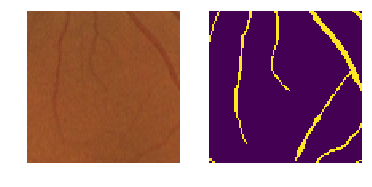

In [8]:
n = np.random.randint(0, X_train.shape[0])
fig, ax = plt.subplots(1,2)
ax[0].imshow(X_train[n])
ax[1].imshow(np.squeeze(Y_train[n, ..., 0]))
for a in ax: a.axis('off')


# Define a convolutional neural network

In [211]:
def UNet():
    '''U net architecture (down/up sampling with skip architecture)
    '''
    from keras.layers import Input, Dropout, Activation, Add, BatchNormalization, Conv2D, Concatenate, UpSampling2D, Activation
    def Conv2DReluBatchNorm(n_filters, kernel_size, strides, inputs):
        x = Conv2D(n_filters, (1,1), strides=1, padding='same', 
                   kernel_initializer='glorot_normal',
                   activation='elu')(inputs)
        x = Conv2D(n_filters, kernel_size, strides=strides, padding='same', 
                   kernel_initializer='glorot_normal',
                   activation='elu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=0.25)(x, training=True) # training + test-time dropout!
        return x

    inputs = Input((None, None, 3))
    
    layer1 = Conv2DReluBatchNorm(32,  (5, 5), (1,1), inputs)
    layer2 = Conv2DReluBatchNorm(64,  (5, 5), (2,2), layer1)
    layer3 = Conv2DReluBatchNorm(128, (3, 3), (2,2), layer2)
    layer4 = Conv2DReluBatchNorm(256, (3, 3), (2,2), layer3)
    layer5 = Conv2DReluBatchNorm(512, (3, 3), (2,2), layer4)

    merge6 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer5), layer4])
    layer6 = Conv2DReluBatchNorm(256, (3, 3), (1,1), merge6)
    
    merge7 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer6), layer3])
    layer7 = Conv2DReluBatchNorm(128, (3, 3), (1,1), merge7)

    merge8 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer7), layer2])
    layer8 = Conv2DReluBatchNorm(64, (3, 3), (1,1), merge8)

    merge9 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer8), layer1])
    layer9 = Conv2DReluBatchNorm(32, (3, 3), (1,1), merge9)

    # treat this binary segmentation as a multiclass segmentation problem (channels = 2)
    mu = Conv2D(2, (1, 1), strides=(1,1), activation='sigmoid', padding='same', name='mu')(layer9)
    # do channel-wise softmax
    #mu = Activation.softmax(axis=-1)(mu)
    # estimate the standard deviation using softplus (for each channel separately?)
    sigma = Conv2D(2, (1, 1), strides=(1,1), activation='softplus', padding='same', name='sigma')(layer9)

    # concatenate mu and sigma for Lx loss
    mu_sigma = Concatenate(axis=-1, name='output')([mu, sigma])

    from keras.models import Model
    # first output (mu_sigma) is used to in Lx_loss to estimate sigma
    # second output (mu) is used in normal classification loss (e.g. cat. crossentropy or multiclass dice)
    return Model(inputs=inputs, outputs=[mu_sigma])




__Compile the network__

To compile the network, we need to choose a loss function and an optimizer. 

As a loss function, we'll use the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).

In [212]:
from keras import backend as K



def kendall_loss(T=10):
    
    def Lx_loss(y_pred):
        from keras import activations
        '''unsupervised loss for standard deviation, based on Monte Carlo sampling'''

        num_classes = K.int_shape(y_pred)[-1] // 2
        mu    = y_pred[...,:num_classes] 
        sigma = y_pred[...,num_classes:] 

        sum_over_t = K.zeros_like(mu)
        for t in range(T):
            # draw N(0,1)
            eps = K.truncated_normal(shape=K.shape(sigma), mean=0.0, stddev=1.0) 
            # compute xhat: Monte Carlo sample of mu, given sigma 
            xhat = mu + sigma*eps
            # after sampling, unaries do not necessarily add up to one anymore
            #  therefore, we apply softmax again
            xhat = activations.softmax(xhat, axis=-1)
            #print(K.eval(xhat))

            # add to sum over t
            ## ?? what is difference between c and c' ?? 
            ## how to compute sum over x_{i,t,c'} such 
            ##  that it has the same dimensionality as x_{i,t,c} ??
            sum_over_t += K.exp(xhat - K.log( K.expand_dims( K.sum( K.exp(xhat), axis=-1 ), axis=-1) ) )
        # take mean over T samples, logarithmize and sum over classes
        Lx = K.sum( K.log( sum_over_t / T ), axis=-1)
        #print(Lx)
        #Lx = activations.softmax(Lx)
        return -Lx


    def Ly_loss(y_true, y_pred):
        targets = y_true
        num_classes = K.int_shape(y_pred)[-1] // 2
        mu = y_pred[...,:num_classes] 
        from keras.losses import categorical_crossentropy
        Ly = categorical_crossentropy(targets, mu)
        #print(Ly)
        return Ly

    def LxLy(y_true, y_pred):
        alpha = 0.5
        return alpha*Lx_loss(y_pred) + (1.0-alpha)*Ly_loss(y_true, y_pred)
    
    return LxLy


In [241]:
from keras import backend as K

#def kendall_loss(T=10):
from keras.activations import softmax
from keras.losses import categorical_crossentropy

T = 0
def kendall_loss(y_true, y_pred):
    num_classes = K.int_shape(y_pred)[-1] // 2
    mu = y_pred[...,:num_classes]
    sigma = y_pred[...,num_classes:]
    
    if T == 0: # if T=0, no sampling is done, revert to conventional cross entropy (ignoring sigma)
        # pull through softmax to get probabilities
        phat = softmax(mu, axis=-1)
        # calculate cross entropy over the sampled predictions
        loss = categorical_crossentropy(y_true, phat)
        return loss
    else: # if T>0, perform Monte Carlo sampling, and return average loss  to conventional cross entropy (ignoring sigma)
        loss = K.zeros_like(mu[...,0])
        for t in range(T):
            # draw random sample with from standard normal distribution
            eps = K.truncated_normal(shape=K.shape(mu), mean=0.0, stddev=1.0) 
            # add sigma-dependent noise to mean predictions 
            xhat = mu + sigma*eps
            # pull through softmax to get probabilities
            phat = softmax(xhat, axis=-1)
            # calculate cross entropy over the sampled predictions
            loss_sample = categorical_crossentropy(y_true, phat)
            loss += loss_sample
        return loss / T

#    return loss


## Test kendall loss

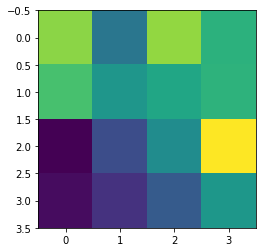

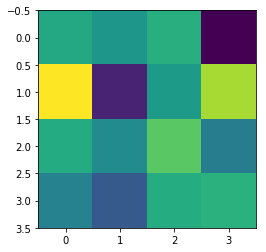

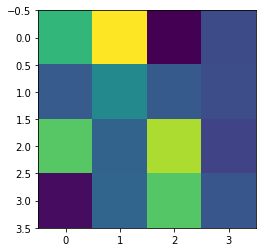

In [242]:
y_true = K.variable(np.random.random((3,4,4,2)))
y_pred = K.variable(np.random.random((3,4,4,4)))
#y_true = K.variable(np.ones((3,4,4,2)))
#y_pred = K.variable(np.ones((3,4,4,4)))
r = K.eval(kendall_loss(y_true, y_pred))
#print(r)

for im in r:
    plt.imshow(np.squeeze(im))
    plt.show()

In [230]:

from keras import backend as K
def dice_coefficient(y_true, y_pred):
    """
    A statistic used for comparing the similarity of two samples. Here binary segmentations.

    Args:
        y_true (numpy.array): the true segmentation
        y_pred (numpy.array): the predicted segmentation

    Returns:
        (float) returns a number from 0. to 1. measuring the similarity y_true and y_pred
    """
    y_true_f=K.flatten(y_true)
    mu     = y_pred
    y_pred_f=K.flatten(mu)
    intersection=K.sum(y_true_f*y_pred_f)
    smooth=1.0
    return (2*intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred[...,0])

def dice_loss2(y_true, y_pred):
    y_pred = y_pred[...,0] # xhat is given as first output
    return 1-dice_coefficient(y_true, y_pred)


def recall_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_true_f) + K.epsilon()))  

def precision_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_pred_f) + K.epsilon()))  

In [243]:
model = UNet()
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model, rankdir='TB', show_shapes=True).create(prog='dot', format='svg'))


In [244]:
model.compile(optimizer='adam', loss=kendall_loss)
print("Number of parameters: ", model.count_params())

Number of parameters:  4452196


# Train the neural network

In [245]:
batch_size = 96
epochs = 10

In [246]:
Y_train.shape

(2000, 96, 96, 2)

In [247]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Train on 2000 samples, validate on 500 samples
Epoch 1/10
2000/2000 [==============================] - 17s 8ms/step - loss: 0.0535 - val_loss: 0.0579
Epoch 2/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0418 - val_loss: 0.0396
Epoch 3/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0399 - val_loss: 0.0394
Epoch 4/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0392 - val_loss: 0.0388
Epoch 5/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0389 - val_loss: 0.0383
Epoch 6/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0387 - val_loss: 0.0381
Epoch 7/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0385 - val_loss: 0.0385
Epoch 8/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0384 - val_loss: 0.0381
Epoch 9/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0383 - val_loss: 0.0378
Epoch 10/10
2000/2000 [===========

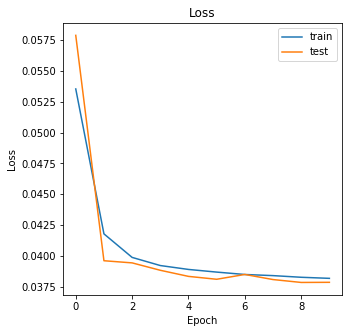

In [248]:
def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax.plot(history.history['loss'])
    if validation:
        ax.plot(history.history['val_loss'])
    ax.set_title('Loss')
    ax.set_ylabel('Loss')
    #ax.set_ylim(bottom=0.)
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'test'])
    
plot_history(history, validation=True)

# Save/load model

In [239]:
#model.save('model_DRIVE_uncertainty_Kendall.h5')

In [240]:
#from keras.models import load_model
#model = load_model('model_DRIVE_uncertainty_Kendall.h5', custom_objects={'loss':kendall_loss})

## Predict with aleatoric uncertainties (no epistemic)

In [249]:
# generate larger images to test
X_predict, Y_predict = get_random_snippets(x_test, y_test, number=100, size=(128,128))

y_pred = model.predict(X_predict)

In [252]:
num_classes = y_pred.shape[-1] // 2
mu    = y_pred[...,:num_classes] > 0.999
sigma = y_pred[...,num_classes:] 


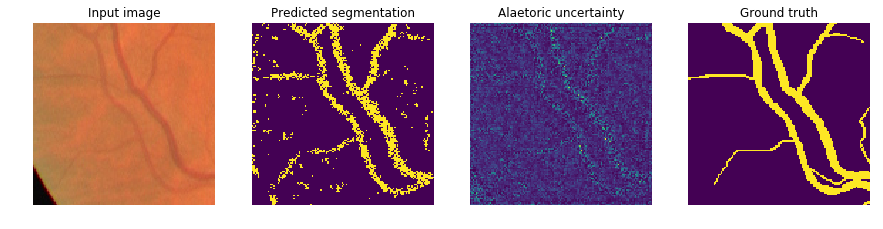

In [253]:
n = 2
fig, ax = plt.subplots(1,4, figsize=(15,5))
ax[0].set_title('Input image')
ax[0].imshow(X_predict[n])

ax[1].set_title('Predicted segmentation')
ax[1].imshow(mu[n, ..., 0])

ax[2].set_title('Alaetoric uncertainty')
ax[2].imshow(sigma[n,...,0])

ax[3].set_title('Ground truth')
ax[3].imshow(Y_predict[n, ..., 0])

for a in ax.flatten(): a.axis('off')

# Predict with aleatoric and epistemic uncertainties

In [57]:
def predict(model, image, gt, T=1):
    
    # add batch dimension
    image = np.expand_dims(image, 0)
    gt = np.expand_dims(gt, 0)
    
    # predict stochastic dropout model T times
    mus = []
    sigmas = []
    for t in range(T):
        print('.', end='')
        y_pred = model.predict(image)
        print(y_pred.shape)
        
        num_classes = y_pred.shape[-1] // 2
        mu    = y_pred[...,:num_classes] 
        sigma = y_pred[...,num_classes:] 
        print(num_classes)
        print(mu.shape)
        print(sigma.shape)
        
        #break
        mus.append( mu )
        sigmas.append( sigmas )
        
    mus = np.array(mus)
    sigmas = np.array(sigmas)
    
    print(mus.shape)
    print(sigmas.shape)
    # mean prediction
    prediction = np.mean(mus, axis=0)
    # threshold mean prediction
    #prediction = np.where(prediction > 0.5, 1, 0)
    
    # estimate uncertainties
    aleatoric = np.mean(sigmas, axis=0)
    epistemic = np.std(mus, axis=0)
    
    #loss, dice, precision, recall = model.evaluate(image, gt, batch_size=1)

    return np.squeeze(prediction), np.squeeze(aleatoric), np.squeeze(epistemic)#, (dice, precision, recall)

# Predict unseen examples

In [58]:
# generate larger images to test
X_predict, Y_predict = get_random_snippets(x_test, y_test, number=100, size=(128,128))

In [ ]:
num = 1
import time
start = time.time()

for i in range(num):
    print(i)
    sample = np.random.randint(0,len(X_predict))
    image = X_predict[sample]
    gt    = Y_predict[sample]
    
    #prediction, aleatoric, epistemic, scores = predict(model, image, gt, T=10)
    prediction, aleatoric, epistemic = predict(model, image, gt, T=1)
    gt    = np.squeeze(gt)
    
    print(prediction.shape)
    print(aleatoric.shape)
    print(epistemic.shape)
    print(gt.shape)
    
    break
    
    n = np.random.randint(0,num)
    fig, ax = plt.subplots(2,3,figsize=(12,6))
    
    #_, dice, recall, precision = score
    #fig.suptitle('Dice: {:.2f}, Recall: {:.2f}, Precision: {:.2f}\n'.format(dice, recall, precision), y=1.0, fontsize=14)
    
    cax0 = ax[0,0].imshow(image)
    plt.colorbar(cax0, ax=ax[0,0])
    ax[0,0].set_title('image')

    cax1 = ax[0,1].imshow(prediction)
    plt.colorbar(cax1, ax=ax[0,1])
    ax[0,1].set_title('prediction')

    cax2 = ax[0,2].imshow(gt)
    plt.colorbar(cax2, ax=ax[0,2])
    ax[0,2].set_title('annotation')
    
    cax3 = ax[1,0].imshow(aleatoric)
    plt.colorbar(cax3, ax=ax[1,0])
    ax[1,0].set_title('aleatoric')
    
    cax4 = ax[1,1].imshow(epistemic)
    plt.colorbar(cax4, ax=ax[1,1])
    ax[1,1].set_title('epistemic')

    cax5 = ax[1,2].imshow(aleatoric+epistemic)
    plt.colorbar(cax4, ax=ax[1,2])
    ax[1,2].set_title('uncertainty (sum)')

    for a in ax.flatten(): a.axis('off')
        
    fig.savefig('prediction_uncertainty_{:03d}.png'.format(i), dpi=300)
    
    plt.show()
    plt.close()

end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))